# Projekt - implementacija afine registracije slike

## Generiranje target i moving slike

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math
from PIL import Image

(127, 161)


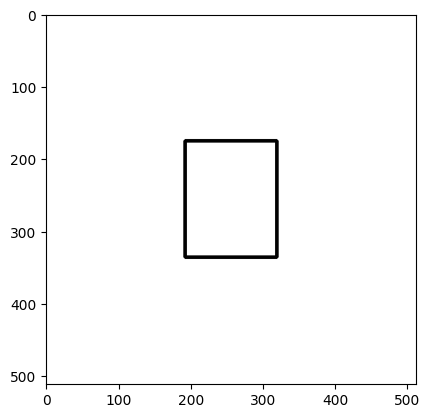

In [3]:
#postavljanje bijele pozadine
img1 = np.zeros((512,512,3), np.uint8)
img1.fill(255)

#dimenzije pravokutnika
height = np.random.randint(100,250)
width = np.random.randint(100,250)
dim = (width, height)

x = int((512 - width)/2.0)
y = int((512 - height)/2.0)
x_end = x + width
y_end = y + height

print(dim)

#crtanje random pravokutnika
target = cv.rectangle(img1, (x, y), (x_end, y_end), color = (1,1,1), thickness = 3)
plt.imshow(target)
plt.show()

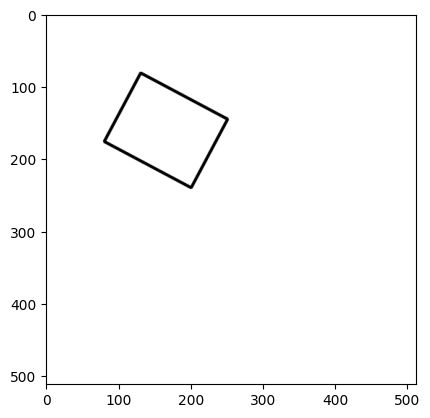

In [8]:
#rotiranje, skaliranje i translacija pravokutnika
centar = (x + width/2, y + height/2)
velicina_moving = np.random.uniform(0.75, 1.25)
kut_rotacije = np.random.randint(0,180)
M = cv.getRotationMatrix2D(centar, kut_rotacije, velicina_moving)
rotirano_skalirano = cv.warpAffine(target, M, target.shape[:2], borderMode=cv.BORDER_CONSTANT, borderValue=(255,255,255))

tx, ty = np.random.randint(-100,100), np.random.randint(-100,100)
trans_matrix = np.array([[1, 0, tx],
                         [0, 1, ty]],
                        dtype = np.float32)
moving = cv.warpAffine(rotirano_skalirano, trans_matrix, rotirano_skalirano.shape[:2], borderMode=cv.BORDER_CONSTANT, borderValue=(255,255,255))

plt.imshow(moving)
plt.show()

## Harris corner detection

In [9]:
# Sobel x-axis kernel
SOBEL_X = np.array((
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]), dtype="int32")

# Sobel y-axis kernel
SOBEL_Y = np.array((
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]), dtype="int32")

# Gaussian kernel
GAUSS = np.array((
    [1/16, 2/16, 1/16],
    [2/16, 4/16, 2/16],
    [1/16, 2/16, 1/16]), dtype="float64")

In [10]:
def convolve(img, kernel):
    if kernel.shape[0] % 2 != 1 or kernel.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")

    img_height = img.shape[0]
    img_width = img.shape[1]
    pad_height = kernel.shape[0] // 2
    pad_width = kernel.shape[1] // 2

    pad = ((pad_height, pad_height), (pad_height, pad_width))
    g = np.empty(img.shape, dtype=np.float64)
    img = np.pad(img, pad, mode='constant', constant_values=0)
    # Do convolution
    for i in np.arange(pad_height, img_height+pad_height):
        for j in np.arange(pad_width, img_width+pad_width):
            roi = img[i - pad_height:i + pad_height +
                      1, j - pad_width:j + pad_width + 1]
            g[i - pad_height, j - pad_width] = (roi*kernel).sum()

    if (g.dtype == np.float64):
        kernel = kernel / 255.0
        kernel = (kernel*255).astype(np.uint8)
    else:
        g = g + abs(np.amin(g))
        g = g / np.amax(g)
        g = (g*255.0)
    return g

In [11]:
def harris(img, threshold=0.6):

    img_cpy = img.copy() # copying image

    img1_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # grayscaling (0-1)

    dx = convolve(img1_gray, SOBEL_X) # convolving with sobel filter on X-axis
    dy = convolve(img1_gray, SOBEL_Y) # convolving with sobel filter on Y-axis

    # square of derivatives
    dx2 = np.square(dx)
    dy2 = np.square(dy)
    dxdy = dx*dy #cross filtering

    # gauss filter for all directions (x,y,cross axis)
    g_dx2 = convolve(dx2, GAUSS)
    g_dy2 = convolve(dy2, GAUSS)
    g_dxdy = convolve(dxdy, GAUSS)

    # Harris Function
    harris = g_dx2*g_dy2 - np.square(g_dxdy) - 0.08*np.square(g_dx2 + g_dy2) # r(harris) = det - k*(trace**2)

    # Normalizing inside (0-1)
    cv.normalize(harris, harris, 0, 1, cv.NORM_MINMAX)

    # find all points above threshold (nonmax supression line)
    loc = np.where(harris >= threshold)

    # drawing filtered points
    for pt in zip(*loc[::-1]):
        cv.circle(img_cpy, pt, 3, (255, 0, 0), -1)

    return img_cpy,g_dx2,g_dy2,dx,dy,loc

### Harris corner detection na target slici

In [12]:
corners_t,g_dx2_t,g_dy2_t,dx_t,dy_t,loc_t = harris(target,0.9)

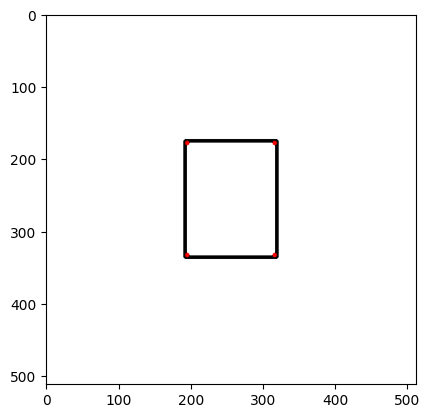

In [14]:
plt.imshow(corners_t)

### Harris corner detection na moving slici

In [15]:
corners_m,g_dx2_m,g_dy2_m,dx_m,dy_m,loc_m = harris(moving,0.75)

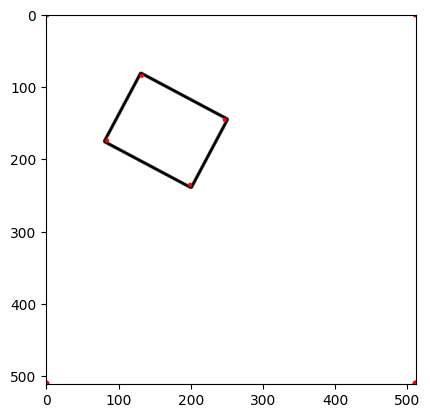

In [61]:
plt.imshow(corners_m)

In [16]:
# označene točke kao kutovi moving pravokutnika, koje želimo smanjiti tako da budu samo pravi kutovi pravokutnika
loc_m

(array([  0,   0,   0,   0,   1,   1,   1,   1,  85, 146, 175, 236, 510,
        510, 510, 510, 511, 511, 511, 511]),
 array([  0,   1, 510, 511,   0,   1, 510, 511, 132, 247,  84, 199,   0,
          1, 510, 511,   0,   1, 510, 511]))

In [17]:
# funkcija koja pretvara array u listu
def lista(xy_arr):
  lista_koor = []
  i = 0
  for i in range(len(xy_arr[0])):
    lista_koor.append((xy_arr[0][i], xy_arr[1][i]))
    i += 1
  return lista_koor

In [18]:
lista_koor = lista(loc_m)
lista_koor

[(0, 0),
 (0, 1),
 (0, 510),
 (0, 511),
 (1, 0),
 (1, 1),
 (1, 510),
 (1, 511),
 (85, 132),
 (146, 247),
 (175, 84),
 (236, 199),
 (510, 0),
 (510, 1),
 (510, 510),
 (510, 511),
 (511, 0),
 (511, 1),
 (511, 510),
 (511, 511)]

In [19]:
# points beyond this threshold are preserved
thresh1 = 20

# funkcija koja računa udaljenost između dvije točke
def distance(pt1, pt2):
    (x1, y1), (x2, y2) = pt1, pt2
    dist = math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
    return dist

## funkcija za micanje duplih kutova
def dupli_kutovi(lista_kutova):
  coor_list = lista_kutova.copy()

  # iterirati za svake dvije točke
  i = 1
  for pt1 in lista_kutova:
      for pt2 in lista_kutova[i::1]:
          if(distance(pt1, pt2) < thresh1):
            # izbjeći uklanjanje točke ako je već uklonjena
            try:
              coor_list.remove(pt2)
            except:
              pass
      i+=1
  return coor_list

In [20]:
coor_list_2 = dupli_kutovi(lista_koor)
coor_list_2

[(0, 0),
 (0, 510),
 (85, 132),
 (146, 247),
 (175, 84),
 (236, 199),
 (510, 0),
 (510, 510)]

In [21]:
## funkcija za micanje kutova u rubovima slike
def rubovi_kutovi(lista_kutova):

  coor_list = lista_kutova.copy()

  for pt1 in lista_kutova:
      if (pt1 == (0,0) or pt1 == (0,1) or pt1 == (1,0) or pt1 == (1,1) or pt1 == (510,0) or pt1 == (510,1) or pt1 == (0,510) or pt1 == (1,510) or pt1 == (510,510)
         or pt1 == (511,0) or pt1 == (511,1) or pt1 == (0,511) or pt1 == (1,511) or pt1 == (511,510) or pt1 == (510,511) or pt1 == (511,511)):
            # izbjeći uklanjanje točke ako je već uklonjena
            try:
              coor_list.remove(pt1)
            except:
              pass

  return coor_list

In [22]:
coor_list_3 = rubovi_kutovi(coor_list_2)
coor_list_3

[(85, 132), (146, 247), (175, 84), (236, 199)]

In [23]:
# funkcija za crtanje popravljenih kutova
def crtanje_kutova(lista_kutova, slika):
  img = slika.copy()
  for pt in lista_kutova:
      cv.circle(img, tuple(reversed(pt)), 3, (255, 0, 0), -1)

  return img

In [24]:
img2 = crtanje_kutova(coor_list_3, moving)

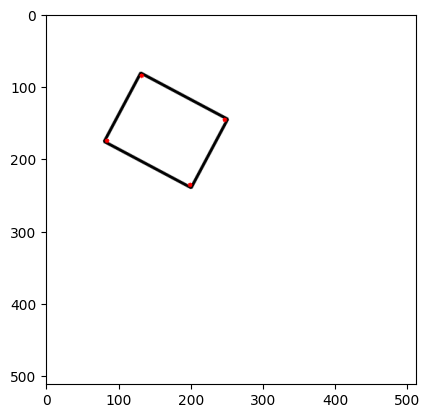

In [25]:
plt.imshow(img2)

### Koordinate kutova i centara oba pravokutnika

In [26]:
# koordinate target slike
lista_koor_t = lista(loc_t)
lista_koor_t

[(178, 195), (178, 316), (333, 195), (333, 316)]

In [27]:
# koordinate moving slike
coor_list_3

[(85, 132), (146, 247), (175, 84), (236, 199)]

In [28]:
## funkcija za centar pravokutnika
def centar(lista_kutova):
  tx = 0
  ty = 0
  for t in lista_kutova:
      tx += t[1]
      ty += t[0]

  return (tx/4, ty/4)

In [29]:
centar_target = centar(lista_koor_t)
centar_target

(255.5, 255.5)

In [30]:
centar_moving = centar(coor_list_3)
centar_moving

(165.5, 160.5)

In [31]:
# pomak moving centra od target centra
Tx = centar_target[0] - centar_moving[0]
Ty = centar_target[1] - centar_moving[1]
TxTy = (Tx, Ty)

## Translacija moving slike

In [32]:
# kod za translaciju slike
def translation_img(img, TxTy, output_shape):
  h,w = img.shape[:2]
  x_pomak = TxTy[0]
  y_pomak = TxTy[1]

  ts_matrix = [[1, 0, x_pomak], [0, 1, y_pomak]]
  out_img = np.zeros(output_shape)

  for i in range(h):
    for j in range(w):
      og_x = j
      og_y = i
      og_xy = [og_x, og_y, 1]

      new_xy = np.dot(ts_matrix, og_xy)
      new_x = int(new_xy[0])
      new_y = int(new_xy[1])

      if 0 < new_x < w and 0 < new_y < h:
        out_img[new_y,new_x] = img[i,j]

  return out_img

In [33]:
trans_moving = translation_img(moving, TxTy, moving.shape)

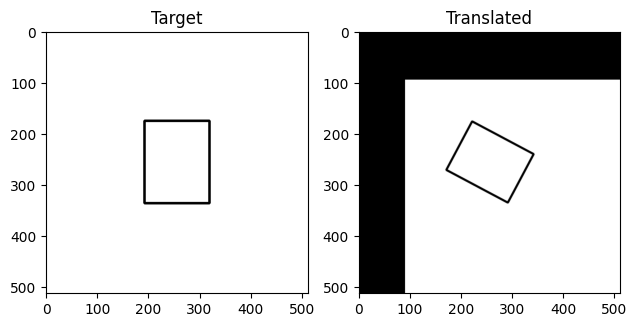

In [34]:
plt.subplot(121)
plt.title("Target")
plt.imshow(target)
plt.subplot(122)
plt.title("Translated")
plt.imshow(trans_moving.astype('uint8'))
plt.tight_layout()
plt.show()

In [35]:
# funkcija za popunjavanje pozadine
def change_background_color(image, target_color=(0, 0, 0), replacement_color=(255, 255, 255)):
    img = Image.fromarray(image)
    pixels = img.load()

    # iterirati kroz svaku točku slike
    width, height = img.size
    for x in range(width):
        for y in range(height):
            # provjeriti odgovara li boja piksela target boji
            if pixels[x, y] == target_color:
                # zamijeniti boju piksela zamjenskom bojom
                pixels[x, y] = replacement_color

    return np.asarray(img)

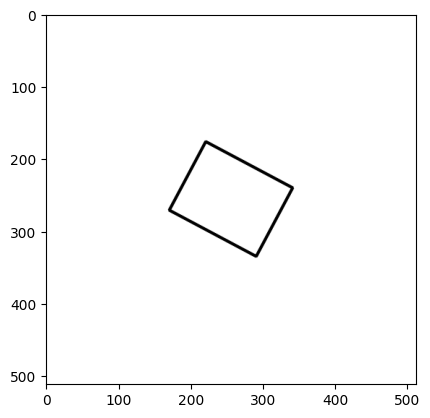

In [36]:
trans_moving = change_background_color(trans_moving.astype('uint8'))
plt.imshow(trans_moving)

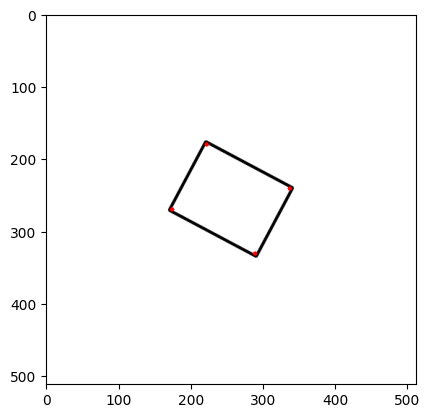

In [37]:
corners_trans,g_dx2_trans,g_dy2_trans,dx_trans,dy_trans,loc_trans = harris(trans_moving,0.75)
lista1_trans = lista(loc_trans)
lista2_trans = dupli_kutovi(lista1_trans)
lista_trans = rubovi_kutovi(lista2_trans)
trans_kutovi = crtanje_kutova(lista_trans, trans_moving)
plt.imshow(trans_kutovi)

In [38]:
lista_trans

[(180, 222), (241, 337), (270, 174), (331, 289)]

## Rotacija moving slike

In [39]:
# funkcija za sortiranje kutova tako da idu redom (u smjeru obrnutom od kazaljke na satu)
def order_vertices(vertices):
    centroid_x, centroid_y = centar(vertices)
    vertices = np.array(vertices)
    angles = np.arctan2(vertices[:, 1] - centroid_y, vertices[:, 0] - centroid_x)
    sorted_indices = np.argsort(angles)
    return vertices[sorted_indices]

In [40]:
ord_lista_trans = order_vertices(lista_trans)
ord_lista_target = order_vertices(lista_koor_t)

In [41]:
# funkcija koja računa rotaciju pravokutnika u ovisnosti o njegovim vrhovima
def calculate_rotation_angle(original_vertices, rotated_vertices):
    num_vertices = len(original_vertices)
    rotation_angles = []

    for i in range(num_vertices):
        original_vector = original_vertices[(i + 1) % num_vertices] - original_vertices[i]
        rotated_vector = rotated_vertices[(i + 1) % num_vertices] - rotated_vertices[i]

        # izračunati kut između dva vektora
        dot_product = np.dot(original_vector, rotated_vector)
        det = original_vector[0]*rotated_vector[1] - original_vector[1]*rotated_vector[0]
        rotation_angle = np.arctan2(det, dot_product)

        rotation_angles.append(rotation_angle)

    return np.degrees(np.median(rotation_angles))

In [42]:
rotation_angle = calculate_rotation_angle(ord_lista_trans, ord_lista_target)
rotation_angle

28.007760679617945

In [43]:
# kod za rotaciju slike
def rotate_image(image, angle):

    angle_rad = np.deg2rad(angle)

    height, width = image.shape[:2]

    # izračunati veličinu platna koja je potrebna da sadrži rotiranu sliku
    max_x = max(abs(width * np.cos(angle_rad)), abs(height * np.sin(angle_rad)))
    max_y = max(abs(width * np.sin(angle_rad)), abs(height * np.cos(angle_rad)))

    # izračunati veličinu platna za rotiranu sliku
    new_height, new_width = int(np.ceil(2 * max_y)), int(np.ceil(2 * max_x))

    # izračunati središte izvorne slike
    center_y, center_x = height / 2, width / 2

    # napraviti prazno platno za rotiranu sliku
    rotated_image = np.zeros((height, width, image.shape[2]), dtype=image.dtype)

    # izračunati centar rotirane slike
    new_center_y, new_center_x = new_height / 2, new_width / 2

    # iterirati svaki piksel rotirane slike
    for y in range(height):
        for x in range(width):
            # pretvoriti koordinate piksela u koordinate na izvornoj slici
            original_y = (y - center_y) * np.cos(angle_rad) + (x - center_x) * np.sin(angle_rad) + center_y
            original_x = -(y - center_y) * np.sin(angle_rad) + (x - center_x) * np.cos(angle_rad) + center_x

            # napraviti bilinearnu interpolaciju
            if 0 <= original_y < height - 1 and 0 <= original_x < width - 1:
                top_left = image[int(np.floor(original_y)), int(np.floor(original_x))]
                top_right = image[int(np.floor(original_y)), int(np.ceil(original_x))]
                bottom_left = image[int(np.ceil(original_y)), int(np.floor(original_x))]
                bottom_right = image[int(np.ceil(original_y)), int(np.ceil(original_x))]

                y_decimal = original_y - np.floor(original_y)
                x_decimal = original_x - np.floor(original_x)

                top = top_left * (1 - x_decimal) + top_right * x_decimal
                bottom = bottom_left * (1 - x_decimal) + bottom_right * x_decimal

                rotated_image[y, x] = top * (1 - y_decimal) + bottom * y_decimal

    return rotated_image

In [44]:
rotated_moving = rotate_image(trans_moving, rotation_angle)

In [45]:
rotated_moving = change_background_color(rotated_moving)

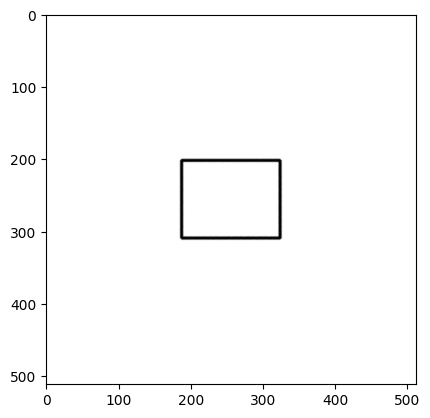

In [46]:
plt.imshow(rotated_moving)

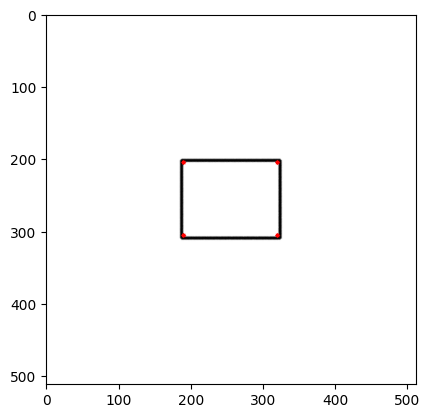

In [47]:
corners_rot,g_dx2_rot,g_dy2_rot,dx_rot,dy_rot,loc_rot = harris(rotated_moving, 0.7)
lista1_rot = lista(loc_rot)
lista2_rot = dupli_kutovi(lista1_rot)
lista_rot = rubovi_kutovi(lista2_rot)
rot_kutovi = crtanje_kutova(lista_rot, rotated_moving)
plt.imshow(rot_kutovi)

In [48]:
# funkcija koja provjerava je li rotirani pravokutnik dobro rotiran

def compare_and_rotate(vertices1, vertices2, image):
    def calculate_angle(center, vertex1, vertex2):
        # izračunati kut koji tvori pravac koji spaja vrh sa središtem i pozitivnu x-os
        angle = np.arctan2(vertex2[1] - center[1], vertex2[0] - center[0]) - np.arctan2(vertex1[1] - center[1], vertex1[0] - center[0])
        angle = np.degrees(angle)
        angle %= 360  # pretvoriti kut da bude u rasponu [0, 360)
        return angle

    # izračunati centre pravokutnika
    center1 = np.mean(vertices1, axis=0)
    center2 = np.mean(vertices2, axis=0)

    # izračunati kutove koje čine linije od središta do prva dva vrha svakog pravokutnika
    angle1 = calculate_angle(center1, vertices1[0], vertices1[1])
    angle2 = calculate_angle(center2, vertices2[0], vertices2[1])

    # provjeriti jesu li kutovi slični
    angle_threshold = 1  # threshold koliko kutovi smiju biti različiti
    if abs(angle1 - angle2) < angle_threshold:
        print("Angles are similar. Doing nothing.")
        return 0
    else:
        print("Angles are different. Rotating image 2 for 90 degrees.")
        return np.rot90(image)

In [49]:
rotated_moving_real = compare_and_rotate(ord_lista_target, lista_rot, rotated_moving)

Angles are different. Rotating image 2 for 90 degrees.


<>:5: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:5: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-50-a77cc8a86223>:5: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if rotated_moving_real is not 0:


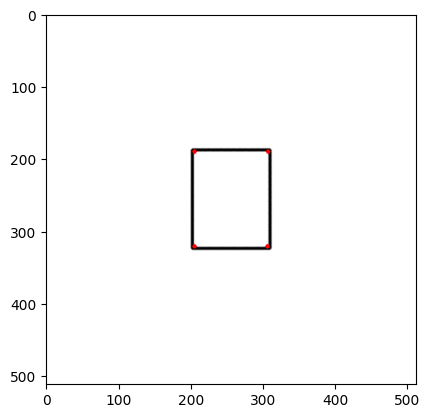

In [50]:
# ako je potrebno dodatno rotirati sliku, spremamo nove vrijednosti
# ako nije potrebno dodatno rotirati sliku, zanemarujemo ovaj dio koda
lista_rot_r = []

if rotated_moving_real is not 0:
  rotated_moving = rotated_moving_real
  corners_rot_r,g_dx2_rot_r,g_dy2_rot_r,dx_rot_r,dy_rot_r,loc_rot_r = harris(rotated_moving_real, 0.7)
  lista1_rot_r = lista(loc_rot_r)
  lista2_rot_r = dupli_kutovi(lista1_rot_r)
  lista_rot_r = rubovi_kutovi(lista2_rot_r)
  rot_r_kutovi = crtanje_kutova(lista_rot_r, rotated_moving_real)
  plt.imshow(rot_r_kutovi)

if lista_rot_r != []:
  lista_rot = lista_rot_r

## Skaliranje moving slike

In [51]:
lista_koor_t, lista_rot

([(178, 195), (178, 316), (333, 195), (333, 316)],
 [(190, 205), (190, 307), (321, 205), (321, 306)])

In [52]:
# funkcija koja računa faktor skaliranja prema vrhovima pravokutnika
def calculate_scaling_factors(original_points, scaled_points):
    # pretvoriti točke u numpy array
    original_points = np.array(original_points)
    scaled_points = np.array(scaled_points)

    # izračunati udaljenosti duž x i y osi
    dist_x_original = np.abs(original_points[1][1] - original_points[0][1])
    dist_x_scaled = np.abs(scaled_points[1][1] - scaled_points[0][1])
    dist_y_original = np.abs(original_points[2][0] - original_points[1][0])
    dist_y_scaled = np.abs(scaled_points[2][0] - scaled_points[1][0])

    scale_x = dist_x_scaled / dist_x_original
    scale_y = dist_y_scaled / dist_y_original

    return scale_x, scale_y

In [53]:
scaling_factors = calculate_scaling_factors(lista_rot, lista_koor_t)
scaling_factors

(1.1862745098039216, 1.183206106870229)

In [54]:
# funkcija za bilinearnu interpolaciju koja pomaže da konačna slika bude što bolje kvalitete
def bilinear_interpolation(image, x, y):
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, image.shape[1] - 1)
    x1 = np.clip(x1, 0, image.shape[1] - 1)
    y0 = np.clip(y0, 0, image.shape[0] - 1)
    y1 = np.clip(y1, 0, image.shape[0] - 1)

    Ia = image[y0, x0]
    Ib = image[y1, x0]
    Ic = image[y0, x1]
    Id = image[y1, x1]

    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    return wa[..., np.newaxis] * Ia + wb[..., np.newaxis] * Ib + wc[..., np.newaxis] * Ic + wd[..., np.newaxis] * Id

In [55]:
# kod za skaliranje slike
def scale_image(image, scaling_factors, output_shape):
    h, w = image.shape[:2]
    scale_x = scaling_factors[0]
    scale_y = scaling_factors[1]

    # izračunati faktore translacije kako bi slika bila centrirana
    tx = (output_shape[1] - w * scale_x) / 2
    ty = (output_shape[0] - h * scale_y) / 2

    scaled_image = np.zeros(output_shape, dtype=np.uint8)

    for i in range(output_shape[0]):
        for j in range(output_shape[1]):
            # izračunati izvorne koordinate koristeći inverznu transformaciju
            og_x = (j - tx) / scale_x
            og_y = (i - ty) / scale_y

            # napraviti bilinearnu interpolaciju
            if 0 <= og_x < w - 1 and 0 <= og_y < h - 1:
                scaled_image[i, j] = bilinear_interpolation(image, og_x, og_y)

    return scaled_image

In [56]:
scaled_moving = scale_image(rotated_moving, scaling_factors, rotated_moving.shape)

In [57]:
scaled_moving = change_background_color(scaled_moving)

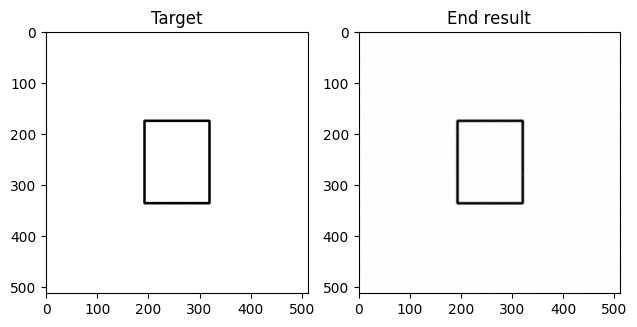

In [58]:
plt.subplot(121)
plt.title("Target")
plt.imshow(target)
plt.subplot(122)
plt.title("End result")
plt.imshow(scaled_moving.astype('uint8'))
plt.tight_layout()
plt.show()

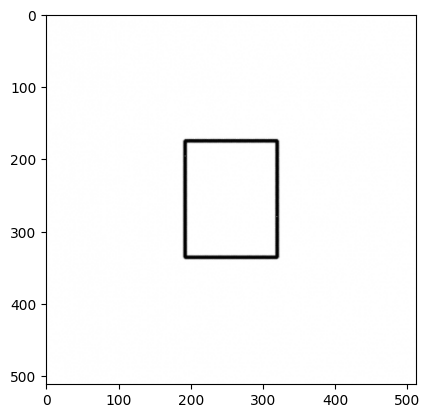

In [59]:
# slika u kojoj prikazujemo oba pravokutnika, jedan iza drugog, da vidimo koliko
# se poklapaju
fig, ax = plt.subplots()

ax.imshow(target)
ax.imshow(scaled_moving, alpha=0.9)
plt.show()